In [11]:
import os
import warnings
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt # Grafik çizimi için gerekli
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

warnings.filterwarnings("ignore")

print("TensorFlow versiyonu:", tf.__version__)


TensorFlow versiyonu: 2.19.0


In [2]:
# Veri seti ana klasörü
 
# ==========================================
# 1. VERİ YÜKLEME VE ÖN İŞLEME
# ==========================================

dataset_path = "panel_data" 
# Temel parametrelerin belirlenmesi
batch_size = 32
img_height = 224
img_width = 224
random_seed = 42

print("Eğitim (Training) veri seti yükleniyor (%70)...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.3,  # Verinin %30'unu doğrulama için ayırıyoruz
  subset="training",     # Bu kısım eğitim alt kümesi
  seed=random_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Doğrulama (Validation) veri seti yükleniyor (%30)...")
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.3,
  subset="validation",   # Bu kısım doğrulama alt kümesi
  seed=random_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Eğitim (Training) veri seti yükleniyor (%70)...
Found 3632 files belonging to 2 classes.
Using 2543 files for training.
Doğrulama (Validation) veri seti yükleniyor (%30)...
Found 3632 files belonging to 2 classes.
Using 1089 files for validation.


In [3]:
# Veri yükleme performansını artırmak için önbellekleme (cache) ve prefetch kullanıyoruz
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# ==========================================
# 2. MODEL MİMARİSİ ( Base Model 1: 2 Conv Layer Basit CNN)
# ==========================================
# Açıklama: 2 Konvolüsyon katmanı (3x3 filtreli), MaxPool, Flatten ve Dense katmanları.
# Amaç: Düşük parametre sayısına sahip, karşılaştırma için temel (benchmark) bir model oluşturmak.

model = models.Sequential([
  # Normalizasyon Katmanı: Piksel değerlerini [0, 255] aralığından [0, 1] aralığına çeker
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  # 1. Konvolüsyon Bloğu
  layers.Conv2D(32, (3, 3), activation='relu'), # 32 filtre, 3x3 boyutunda
  layers.MaxPooling2D(),                        # Boyut azaltma
  
  # 2. Konvolüsyon Bloğu
  layers.Conv2D(64, (3, 3), activation='relu'), # 64 filtre, 3x3 boyutunda
  layers.MaxPooling2D(),                        # Boyut azaltma
  
  # Düzleştirme ve Tam Bağlantılı (Dense) Katmanlar
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  
  # Çıkış Katmanı
  # İkili sınıflandırma (Kirli/Temiz) olduğu için 1 nöron ve 'sigmoid' aktivasyonu kullanılır
  layers.Dense(1, activation='sigmoid')
])

# Modelin özetini yazdıralım (Katmanlar ve parametre sayıları)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ==========================================
# 3. MODEL DERLEME
# ==========================================

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Optimizasyon algoritması: Adam
              loss='binary_crossentropy',                              # Kayıp fonksiyonu: İkili sınıflandırma için
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),   # Ek metrik: Kesinlik
                       tf.keras.metrics.Recall(name='recall')])        # Ek metrik: Duyarlılık

In [6]:
# ==========================================
# 4. EĞİTİM (TRAINING)
# ==========================================

# HATA ÇÖZÜMÜ: EarlyStopping kütüphanesini buraya dahil ediyoruz
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping: Doğrulama kaybı (val_loss) 3 epoch boyunca iyileşmezse eğitimi durdurur
# ve en iyi ağırlıkları geri yükler.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 30 # Maksimum epoch sayısı

print("Eğitim başlıyor...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop] # Early stopping callback'ini ekliyoruz
)

Eğitim başlıyor...
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.5691 - loss: 2.4195 - precision: 0.5733 - recall: 0.5881 - val_accuracy: 0.6694 - val_loss: 0.6354 - val_precision: 0.6211 - val_recall: 0.9161
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.7099 - loss: 0.5616 - precision: 0.7150 - recall: 0.7485 - val_accuracy: 0.7530 - val_loss: 0.5245 - val_precision: 0.7445 - val_recall: 0.7911
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.7951 - loss: 0.4541 - precision: 0.8068 - recall: 0.8020 - val_accuracy: 0.7815 - val_loss: 0.4941 - val_precision: 0.7710 - val_recall: 0.8179
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8949 - loss: 0.2983 - precision: 0.9060 - recall: 0.8877 - val_accuracy: 0.7989 - val_loss: 0.4891 - val_precision: 0.8007 - val_recall: 0.8107
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.9597 - loss: 0.1390 - precision: 0.9692 - recall: 0.9522 - val_accurac

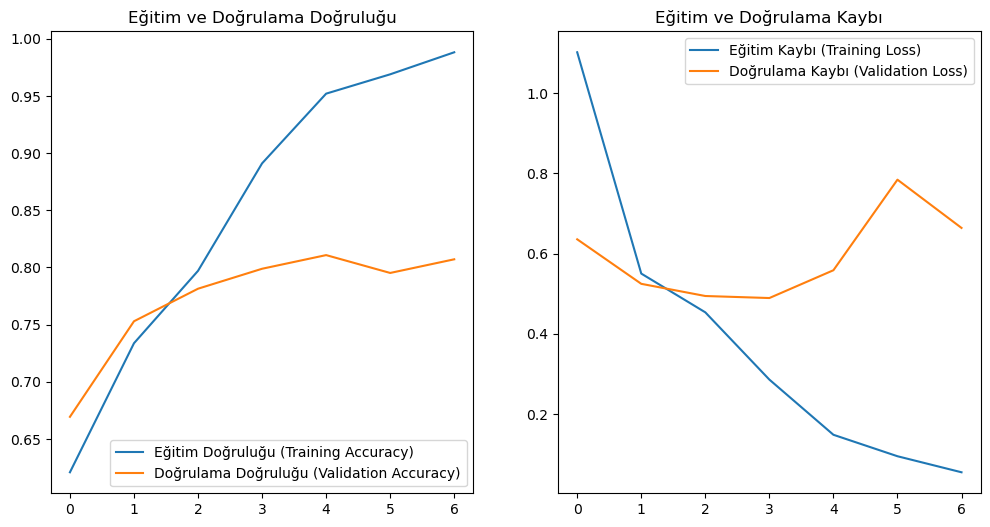

Model başarıyla kaydedildi: FET312_22040301090_PATtechs_model_1.h5


In [7]:
# ==========================================
# 5. SONUÇLAR VE GRAFİKLER
# ==========================================

# Eğitim geçmişinden verileri alalım
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Grafik çizimi
plt.figure(figsize=(12, 6))

# Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Accuracy)')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Accuracy)')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

# Modeli dosya olarak kaydetme (.h5 formatında)
model_save_name = 'FET312_22040301090_PATtechs_model_1.h5'
model.save(model_save_name)
print(f"Model başarıyla kaydedildi: {model_save_name}")

Found 3632 files belonging to 2 classes.
Using 1089 files for validation.
Analiz için tahminler yapılıyor...


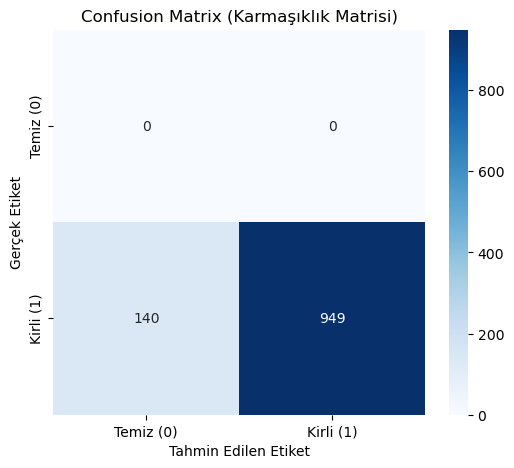


--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

       Temiz       0.00      0.00      0.00         0
       Kirli       1.00      0.87      0.93      1089

    accuracy                           0.87      1089
   macro avg       0.50      0.44      0.47      1089
weighted avg       1.00      0.87      0.93      1089



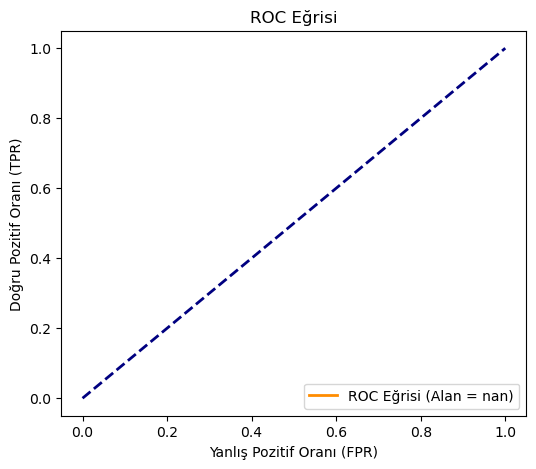

In [12]:
# ==========================================
# 6. DETAYLI PERFORMANS ANALİZİ (RAPOR İÇİN)
# ==========================================

# Doğrulama setini karıştırmadan (shuffle=False) tekrar yüklüyoruz
val_ds_eval = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=random_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False # Sıralamanın bozulmaması önemli
)

# Tahminleri al
y_true = []
y_pred_probs = []

print("Analiz için tahminler yapılıyor...")
for images, labels in val_ds_eval:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions.flatten())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Temiz (0)', 'Kirli (1)'], 
            yticklabels=['Temiz (0)', 'Kirli (1)'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Confusion Matrix (Karmaşıklık Matrisi)')
plt.show()

# 2. Sınıflandırma Raporu
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred_classes, target_names=['Temiz', 'Kirli']))

# 3. ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Eğrisi (Alan = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

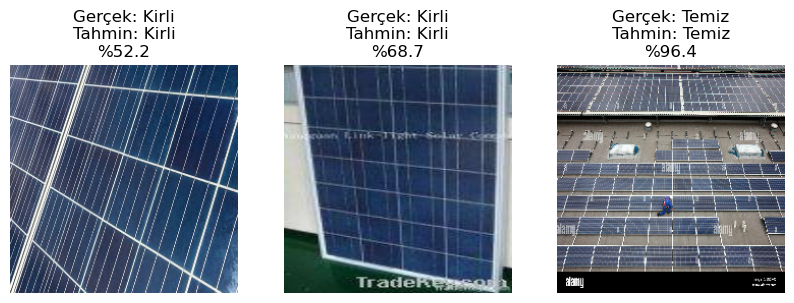

In [13]:
# ==========================================
# 7. TEKİL GÖRÜNTÜ TESTİ (DEMO)
# ==========================================

plt.figure(figsize=(10, 5))
# Doğrulama setinden bir batch al
for images, labels in val_ds.take(1):
    for i in range(3): # İlk 3 görüntüyü test et
        ax = plt.subplot(1, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        
        # Model ile tahmin yap
        img_array = tf.expand_dims(images[i], 0)
        prediction = model.predict(img_array, verbose=0)[0][0]
        
        true_label = "Kirli" if labels[i] == 1 else "Temiz"
        pred_label = "Kirli" if prediction > 0.5 else "Temiz"
        confidence = 100 * prediction if prediction > 0.5 else 100 * (1 - prediction)
        
        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\n%{confidence:.1f}")
        plt.axis("off")